In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

## Download dataset

In [2]:
ROOT_DATA_DIR = "FashionMNISTDir"

train_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor()
    )


test_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train = False, ## <<< Test data
    download = True,
    transform = transforms.ToTensor()
    )

In [3]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [4]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [5]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3:' Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
    }

## Visualize one sample

In [6]:
def view_sample_img(data, index, label_map):
    plt.imshow(data.data[index], cmap="gray")
    plt.title(f"data label: {label_map[data.targets[index].item()]}")
    plt.axis("off")

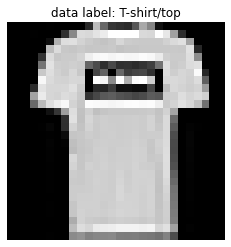

In [7]:
view_sample_img(train_data, index=1, label_map=label_map)

## Create the dataloader

In [8]:
BATCH_SIZE = 64

train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
    )

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = True
    )

In [9]:
for data, label in test_data_loader:
    print(data.shape)    
    print(label.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## CNN architecture

pytorch doc - [reference](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()
        
        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.Flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)
        
    
    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = self.FC_02(x)        
        x = self.FC_03(x)
        return x

In [12]:
model = CNN(1, 10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

## Count no. of trainable params

In [13]:
def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = 0
    for name, parameters in model.named_parameters():
        if not parameters.requires_grad:
            continue
        param = parameters.numel()
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total trainable parameters: {total}")
    return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [14]:
next(model.parameters()).is_cuda

True

## Traning loop

In [15]:
learning_rate = 0.001
num_epochs = 20

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
n_total_steps = len(train_data_loader)
n_total_steps

938

In [18]:
60000/BATCH_SIZE

937.5

In [19]:
for epoch in range(num_epochs):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            
            images = images.to(device)
            labels = labels.to(device)   
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tqdm_epoch.set_postfix(loss=loss.item())

            

Epoch 20/20: 100%|██████████| 938/938 [00:16<00:00, 57.84it/s, loss=0.233] 


In [20]:
os.getcwd()

'd:\\oneNeuron\\Pytorch\\Pytorch-basics\\codebase'

In [21]:
## save trained model -
os.makedirs("06_03_session_dir", exist_ok=True)
modle_file = os.path.join("06_03_session_dir", 'CNN_model.pth')
torch.save(model, modle_file)